# Predicting Air Quality for Outdoor Activities


## Authors

BelManuel Soto Team:

 - Beltran Vazquez Liniers
 - Lucia Morerira
 - Nirbhaya Shaji


## External links and resources
Paste here all the links to external resources that are necessary to understand and run your code. Add descriptions to make it clear how to use them during evaluation.


European Union Pollutant emissions from transport: https://ec.europa.eu/eurostat/databrowser/view/t2020_rk300/default/table?lang=en

European Union air polluants by source sector (we use only car passengers origin): https://ec.europa.eu/eurostat/databrowser/view/ENV_AIR_EMIS__custom_990087/default/table?lang=en

## What is air pollution?

Air pollution is the result of gas and particle emissions, and the chemical reactions they have in the atmosphere. It can be caused by natural sources like volcanic eruptions. But the majority is caused by five types of human activity: household, industry, transportation, agriculture, and waste.

According to UN, there are two types specially dangerous: Ground-level Ozone and PM2.5. 

 - Particulate matter, or PM2.5, is very small particles in air that are 2.5 micrometers or less in diameter. Particulate matter, is a mixture that can include organic chemicals, dust, soot and metals. These particles come from cars and trucks, factories, wood burning, and other activities.

 - Ground-level Ozone (Tropospheric) is both greenhouse gas and air polluant. It is not directly emitted into the air. It is a product of chemical reactions from Oxides of Nitrogen (NOx) and Volatile Organic Compounds (VOC). These polluants came from cars, power plants, refineires and chemical plants, they react in presence of sunlight. Usually high Ozone levels is related to hot sunny days in urban environments, but can also reach high levels in winter or be transported by wind into rural areas.

There are other polluants substances, such as, Carbone Monoxide, Sulfure Dioxide, methane and chlorofluorocarbons.



## Consecuencies of air pollution high levels

Exposure to high levels of air pollution can cause a variety of adverse health outcomes. It increases the risk of respiratory infections, heart disease and lung cancer.  Both short and long term exposure to air pollutants have been associated with health impacts.  More severe impacts affect people who are already ill.  Children, the elderly and poor people are more susceptible.  The most health-harmful pollutants – closely associated with excessive premature mortality –  are fine PM2.5 particles that penetrate deep into lung passageways. 

Source: WHO

## World Environemt Day

Next June 5th is a very special day in our lifes because of two reasons:

 - World Environment Day
 - Final Top 10 WDL classification

For the first (and most important) event of June 5th, UNO organizes lots of events around the world, you can find your favorites in this website https://www.worldenvironmentday.global/




## Our bit to save the environment

This is it, our contribution to save the planet is this repository, in which we tackle the air pollution quality. We deal with Cascais and its suburbs air pollution data.

There are several sensors located in specific places in order to measure unusual concentration levels of different substances, such as, Nitrogens and Ozone. Also the fine particulates recently defined (PM2.5 and PM10). 

The data organization has provided us includes a historical data from May'20 to May'21 with the daily concentration levels of these polluant gases. Measurements are made in micrograms per cubic meter, except Carbon monoxide, which is in miligrams per cubic meter. Also includes metheorological data, such as temperature, relative humidity and wind speed.

We start making some descriptive analysis about polluants and air quality. 

In next section we want to know how is Portugal face to their neighbours countries

Then we modelize and predict air quality for the next days, in order to propose or limit actions in function of these predicted conditions

Finally, we propose a tool with free acces to everyone in order to know the air situation. We want people watch the air quality with the same curiosity as they watch weather.

In the Future work section, we will recommend some actions to the authorities in order to make consciousness people and encourage them.

## QUALAR

Qualar is an entity managed by Agência Portuguesa do Ambiente. In its website you can see the current polluant values as well as their historical data.

They write the guidelines in Portugal to define air quality standards. With that intention they have created the next table in order to help users know how breathable is their air. 

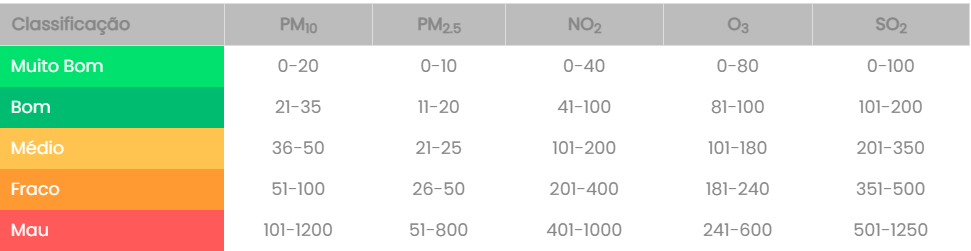


source: https://qualar.apambiente.pt/

## Data cleaning & preparation

The first step as always is to import and clean data

### Cleaning

In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import json 
!pip install geopandas
import geopandas as gpd

!pip install statsmodels==0.12.1
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.arima_model import ARIMA

from tqdm import tqdm_notebook

from itertools import product

from sklearn.cluster import AgglomerativeClustering, KMeans
!pip install kneed
from kneed import KneeLocator

import warnings
warnings.filterwarnings("ignore")

We import a csv file with the concatenation of the historical information for every sensor station.

In [2]:
data = pd.read_csv('/content/sample_data/base_ini_air_quality.csv', sep = ";",encoding='latin-1')
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')
data = data.sort_values('date')

data.loc[data['id'].str.contains('QA00NO'), 'polluant'] = 'Nitrogen'
data.loc[data['id'].str.contains('QA0NO2'), 'polluant'] = 'Nitrogen Dioxide'
data.loc[data['id'].str.contains('QA00O3'), 'polluant'] = 'Ozono'
data.loc[data['id'].str.contains('QAPM25'), 'polluant'] = 'Fine Particulate matter 2.5'
data.loc[data['id'].str.contains('QA0SO2'), 'polluant'] = 'Sulfure Dioxide'
data.loc[data['id'].str.contains('QAPM10'), 'polluant'] = 'Fine Particulate matter 10'
data.loc[data['id'].str.contains('QA00CO'), 'polluant'] = 'Carbon Monoxide'
data.loc[data['id'].str.contains('RULAEQ'), 'polluant'] = 'Decibel'
data.loc[data['id'].str.contains('ME00PA'), 'polluant'] = 'Athmosferic Pressure'
data.loc[data['id'].str.contains('ME00HR'), 'polluant'] = 'Relative Humidity'
data.loc[data['id'].str.contains('METEMP'), 'polluant'] = 'Air Temperature'
data.loc[data['id'].str.contains('ME00VI'), 'polluant'] = 'Wind Speed'
data.loc[data['id'].str.contains('ME00VD'), 'polluant'] = 'Wind Direction'
data.loc[data['id'].str.contains('ME00PP'), 'polluant'] = 'Precipitation'

After data importing, we look for outlier values which could make interferences in our analysis. We start boxploting the polluant values. The first thing stands out is that Sulfure Dioxide indicator doesn't work in any station. 

On the other hand, every polluant distribution have a lot of values upper 3th quartile, however the most of them are still normal values, according to Qualar.pt standard levels. 

In spite of that, we want to deep in the analysis because PM2.5 and PM10 have values extremely high. In this case we smooth the series with two bounds, upper and lower. These bounds depend on mean absolute error, obteined from difference between real data and smoothed values. We consider outliers values above (or below) this interval.

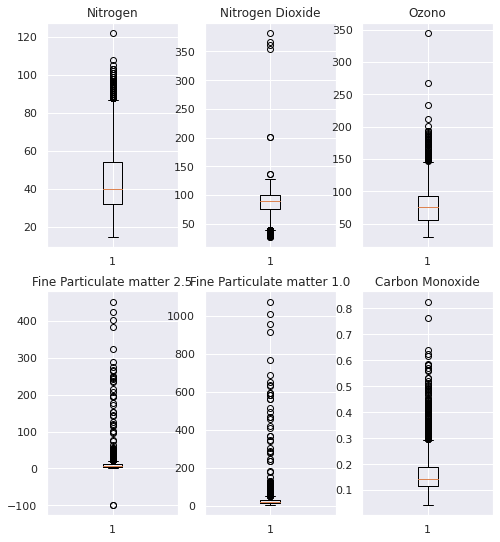

In [12]:
plt.figure(figsize=(8,14))
for i in range(6):
  plt.subplot(3,3, i+1)
  if i==0:
    df = data[data['polluant'] == 'Nitrogen']
    plt.boxplot(df['value'])
    plt.title('Nitrogen')
  if i==1:
    df = data[data['polluant'] == 'Nitrogen Dioxide']
    plt.boxplot(df['value'])
    plt.title('Nitrogen Dioxide')
  if i==2:
    df = data[data['polluant'] == 'Ozono']
    plt.boxplot(df['value'])
    plt.title('Ozono')
  if i==3:
    df = data[data['polluant'] == 'Fine Particulate matter 2.5']
    plt.boxplot(df['value'])
    plt.title('Fine Particulate matter 2.5')
  if i==4:
    df = data[data['polluant'] == 'Fine Particulate matter 1.0']
    plt.boxplot(df['value'])
    plt.title('Fine Particulate matter 1.0')
  if i==5:
    df = data[data['polluant'] == 'Carbon Monoxide']
    plt.boxplot(df['value'])
    plt.title('Carbon Monoxide')

Next, the smothing analysis. We show Manique PM2.5 values as example. We have defined two functions. The first one helps us calculates de bounds. Second one smooth and plot the series.

In [38]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

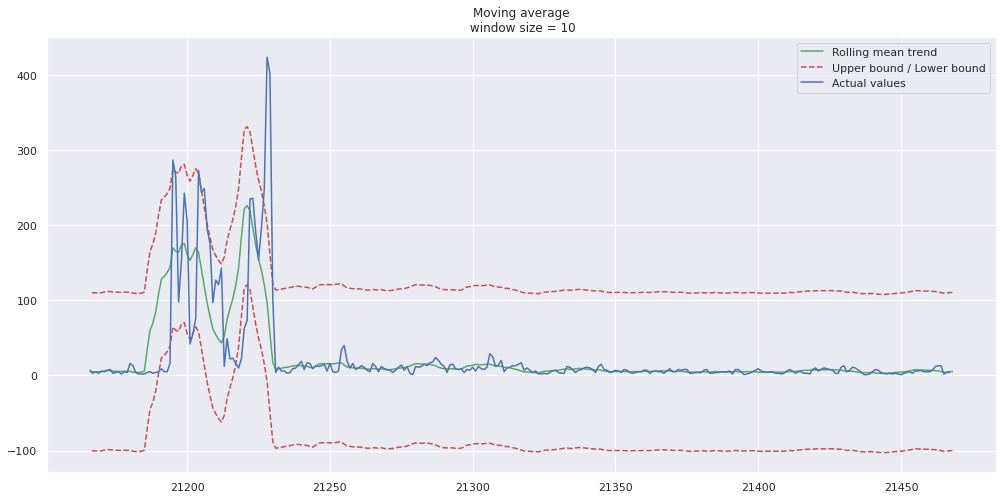

In [45]:
# We smooth Manique values of PM2.5, we suspect there are outliers there
Manique_outl = data[(data['polluant'] == 'Fine Particulate matter 2.5') & (data['address'] == 'Manique')][['value']]
Manique_outl = Manique_outl

# Smooth by the previous 10 days
plot_moving_average(Manique_outl, 10, plot_intervals=True)

Finally, we fix data because as we see in the graphic above, in the begining of the series there are unusual values. We limit data, not delete, in order to reduce information lose. First we eliminate negative values, which are not necessarly wrong, but responds to special cases values, such as no observations or inoperational sensor.

Then we limit PM2.5 and PM10. Of course respecting Qualar values, that's to convert max values into "normal" values inside the upper Qualar interval ("Mau" level in these two indicators starts from 51 and 101 mcrg/m3 respectively). 

In [4]:
data.loc[data.value < 0, 'value'] = None
# We limit PM25 and PM10 outliers to the Very bad limits
data.loc[(data['polluant'] == 'Fine Particulate matter 2.5') & (data['value'] > 50) , 'value'] = 51
data.loc[(data['polluant'] == 'Fine Particulate matter 10') & (data['value'] > 100) , 'value'] = 101

### Preparation

In the preparation section we input in the dataset the air quality classification.

In [3]:
# interval values following standrads from Associaçao Portuguesa do Ambiente 

data.loc[(data['polluant'] == 'Nitrogen Dioxide') & (data['value'] <= 40) , 'Level'] = 1
data.loc[(data['polluant'] == 'Nitrogen Dioxide') & (data['value'].between(40,100)) , 'Level'] = 2
data.loc[(data['polluant'] == 'Nitrogen Dioxide') & (data['value'].between(101,200)) , 'Level'] = 3
data.loc[(data['polluant'] == 'Nitrogen Dioxide') & (data['value'].between(201,400)) , 'Level'] = 4
data.loc[(data['polluant'] == 'Nitrogen Dioxide') & (data['value'] > 400) , 'Level'] = 5

data.loc[(data['polluant'] == 'Ozono') & (data['value'] <= 80) , 'Level'] = 1
data.loc[(data['polluant'] == 'Ozono') & (data['value'].between(40,100)) , 'Level'] = 2
data.loc[(data['polluant'] == 'Ozono') & (data['value'].between(101,180)) , 'Level'] = 3
data.loc[(data['polluant'] == 'Ozono') & (data['value'].between(181,240)) , 'Level'] = 4
data.loc[(data['polluant'] == 'Ozono') & (data['value'] > 240 ) , 'Level'] = 5

data.loc[(data['polluant'] == 'Sulfure Dioxide') & (data['value'] <= 100) , 'Level'] = 1
data.loc[(data['polluant'] == 'Sulfure Dioxide') & (data['value'].between(100,200)) , 'Level'] = 2
data.loc[(data['polluant'] == 'Sulfure Dioxide') & (data['value'].between(201,350)) , 'Level'] = 3
data.loc[(data['polluant'] == 'Sulfure Dioxide') & (data['value'].between(351,500)) , 'Level'] = 4
data.loc[(data['polluant'] == 'Sulfure Dioxide') & (data['value'] > 500 ) , 'Level'] = 5

data.loc[(data['polluant'] == 'Fine Particulate matter 2.5') & (data['value'] <= 10) , 'Level'] = 1
data.loc[(data['polluant'] == 'Fine Particulate matter 2.5') & (data['value'].between(11,20)) , 'Level'] = 2
data.loc[(data['polluant'] == 'Fine Particulate matter 2.5') & (data['value'].between(21,25)) , 'Level'] = 3
data.loc[(data['polluant'] == 'Fine Particulate matter 2.5') & (data['value'].between(26,50)) , 'Level'] = 4
data.loc[(data['polluant'] == 'Fine Particulate matter 2.5') & (data['value'] > 50 ) , 'Level'] = 5

data.loc[(data['polluant'] == 'Fine Particulate matter 1.0') & (data['value'] <= 20) , 'Level'] = 1
data.loc[(data['polluant'] == 'Fine Particulate matter 1.0') & (data['value'].between(21,35)) , 'Level'] = 2
data.loc[(data['polluant'] == 'Fine Particulate matter 1.0') & (data['value'].between(36,50)) , 'Level'] = 3
data.loc[(data['polluant'] == 'Fine Particulate matter 1.0') & (data['value'].between(51,100)) , 'Level'] = 4
data.loc[(data['polluant'] == 'Fine Particulate matter 1.0') & (data['value'] > 100 ) , 'Level'] = 5

level_max = pd.DataFrame(data.groupby(["address","date"])['Level'].max()).reset_index()
data = data.merge(level_max, left_on = ['address','date'], right_on = ['address','date'], how = 'left')
data= data.rename(columns = {'Level_y':'QA_level'})
data = data[['id','address','date','polluant','value','unit','QA_level']]
#data

In [4]:
data.loc[data['QA_level'] == 1 , 'QA_class'] = '1.-Very Good'
data.loc[data['QA_level'] == 2 , 'QA_class'] = '2.-Good'
data.loc[data['QA_level'] == 3 , 'QA_class'] = '3.-Moderate'
data.loc[data['QA_level'] == 4 , 'QA_class'] = '4.-Bad'
data.loc[data['QA_level'] == 5 , 'QA_class'] = '5.-Very Bad'
#data

## Descriptive analysis

### Main concentration gases

We start the descriptive analysis showing the median value for every freguesia. Which are the highest polluants concentrations and where?

In [73]:
data_polluant = data.pivot_table(values = 'value', index = 'address', columns = 'polluant', aggfunc = ['median'], margins = True, fill_value = 0).round(2)
data_polluant = data_polluant.droplevel(0, axis=1)
data_polluant[['Nitrogen','Nitrogen Dioxide','Ozono','Fine Particulate matter 10','Fine Particulate matter 2.5','Carbon Monoxide']]

polluant,Nitrogen,Nitrogen Dioxide,Ozono,Fine Particulate matter 10,Fine Particulate matter 2.5,Carbon Monoxide
address,,,,,,
Aboboda,53,89.0,88.0,20.0,7,0.14
Alcabideche,65,101.0,67.5,19.0,7,0.14
Cascais,49,87.5,36.0,20.0,7,0.18
Estoril,38,96.0,78.5,18.0,6,0.16
Guincho,32,101.0,79.5,28.0,11,0.11
Malveira,15,83.0,84.5,13.0,4,0.14
Manique,41,39.0,52.0,19.5,7,0.13
Murtal,35,97.0,82.0,15.0,5,0.11
Parede,92,99.0,82.0,19.0,7,0.15


Guincho have several indicators above the general median, such as Nitrogen Dioxide, PM10 and PM2.5. Malveira median values are always under the general median value (except Ozone), especially on PM2.5 which is one of the most dangerous indicators.

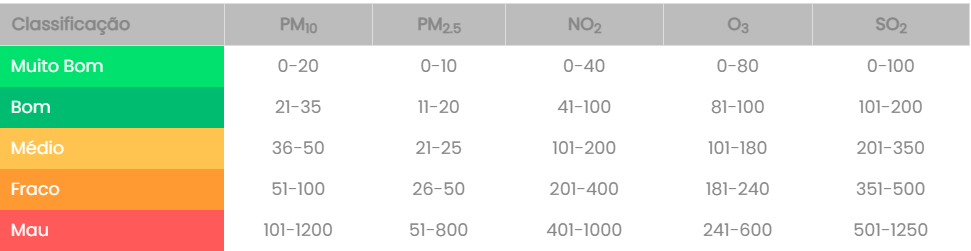


source: https://qualar.apambiente.pt/

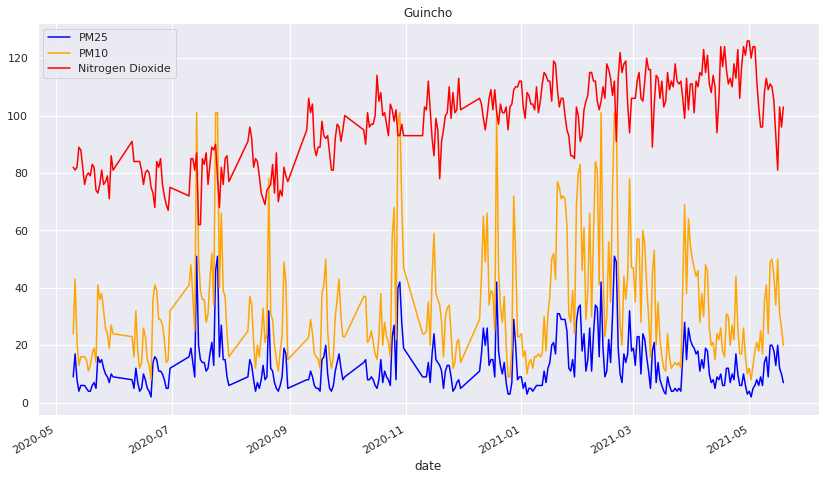

In [77]:
fig = plt.figure(figsize=(14, 8))

df = data[(data['address'] == 'Guincho')]
PM25 = df[df['polluant'] == 'Fine Particulate matter 2.5'].set_index('date')
PM25['value'].plot(color = 'blue', label = 'PM25')

df = data[(data['address'] == 'Guincho')]
PM10 = df[df['polluant'] == 'Fine Particulate matter 10'].set_index('date')
PM10['value'].plot(color = 'orange', label = 'PM10')

df = data[(data['address'] == 'Guincho')]
nitro_diox = df[df['polluant'] == 'Nitrogen Dioxide'].set_index('date')
nitro_diox['value'].plot(color = 'red', label = 'Nitrogen Dioxide')

plt.title('Guincho')
plt.xticks(rotation=30, ha='right')
plt.legend(loc=2)
 

First we show historical data from Guincho of PM10, PM2.5 and Nitrogen Dioxide. We have chosen these polluants because are the highest at Guincho. Variation in PM10 is higher than the other indicators.

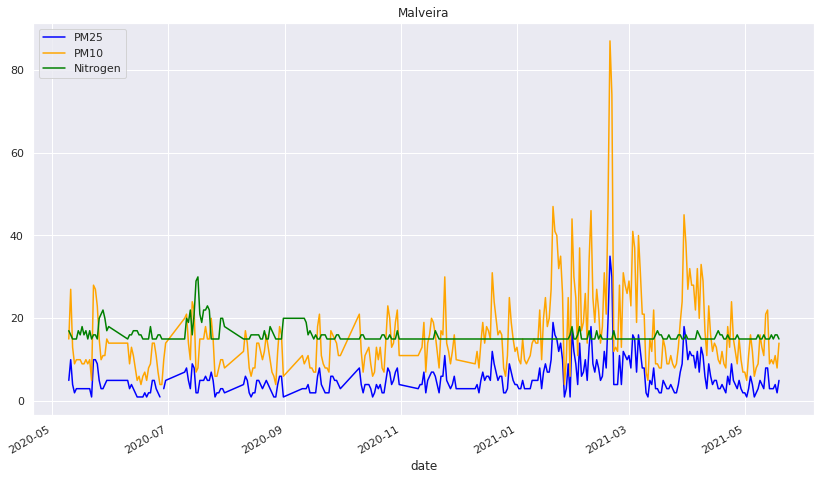

In [79]:
fig = plt.figure(figsize=(14, 8))
#fig, ax = plt.subplots(1)
df = data[(data['address'] == 'Malveira')]
PM25 = df[df['polluant'] == 'Fine Particulate matter 2.5'].set_index('date')
PM25['value'].plot(color = 'blue', label = 'PM25')

df = data[(data['address'] == 'Malveira')]
PM10 = df[df['polluant'] == 'Fine Particulate matter 10'].set_index('date')
PM10['value'].plot(color = 'orange', label = 'PM10')

df = data[(data['address'] == 'Malveira')]
nitro = df[df['polluant'] == 'Nitrogen'].set_index('date')
nitro['value'].plot(color = 'green', label = 'Nitrogen')

plt.title('Malveira')
plt.xticks(rotation=30, ha='right')
plt.legend(loc=2)

Then the lowest polluants at Malveira. PM10 variability is again the most sensitive to changes. Meanwhile Nitrogen is quite stable

### Air quality photo

The table below counts the percentage of days every freguesia are in the different air quality levels.

Next we want to answer the question... Which freguesias have usually better air quality? The answer is Cascais, it has more than 88% of the days with 'Good' air quality and less than 2% of the days are 'Very Bad'. Manique has also 'Good' quality the most part of time, but its 'Very Bad' frequency is the highest. Almost 9% of the days, when the total 'Very Bad' days is 1.4% 

In [39]:
data.groupby(['QA_class','address'])['date'].count()
data_PT = data.pivot_table(values = 'value', index = 'address', columns = 'QA_class', aggfunc = ['count'], margins = True, fill_value = 0)
data_PT = data_PT.droplevel(0, axis=1)

data_PT['1.-VeryGood_%'] = 100 * data_PT['1.-Very Good'] / data_PT['All']
data_PT['2.-Good_%'] = 100 * data_PT['2.-Good'] / data_PT['All']
data_PT['3.-Moderate_%'] = 100 * data_PT['3.-Moderate'] / data_PT['All']
data_PT['4.-Bad_%'] = 100 * data_PT['4.-Bad'] / data_PT['All']
data_PT['5.-VeryBad_%'] = 100 * data_PT['5.-Very Bad'] / data_PT['All']

air_classif = data_PT[['1.-VeryGood_%','2.-Good_%','3.-Moderate_%','4.-Bad_%','5.-VeryBad_%']].round(2)
air_classif

QA_class,1.-VeryGood_%,2.-Good_%,3.-Moderate_%,4.-Bad_%,5.-VeryBad_%
address,,,,,
Aboboda,0.00,68.42,30.29,1.29,0.00
Alcabideche,0.00,39.10,59.22,1.68,0.00
Cascais,0.00,88.14,9.94,1.60,0.32
Estoril,0.00,58.67,37.33,3.66,0.34
Guincho,0.00,39.10,50.74,9.20,0.96
Malveira,0.00,74.01,23.35,1.97,0.67
Manique,1.01,77.63,10.89,1.68,8.80
Murtal,0.00,49.32,50.14,0.54,0.00
Parede,0.00,41.67,52.88,3.21,2.24


### Portugal current air quality situation face to Europe

Next, we make a point on Portugal situation face other european neighbours countries. We focus on transport emissions because according to the UNO and the EU this is the most important source of air polluants.

We have recuperated data from EUROSTAT. In particular, information about PM10 and PM2.5 particulates emited by transport actions. 

One one hand, we have the total tonnes on PM2.5 particules which origin is from road transport from passenger cars. With this data we paint the evolution of Portugal and its neighbours from 2009 to 2018. As we see Portual is the lowest emisor, but also the country which less reduce its emisions. 

UE_PM10_transport_evolution file includes the relative emisions of PM10 particules face to year 2000 (in %), which is the year of reference. This emissions have their origin in transport. In short we will use this dataframe to build a cluster analysis by country. The target of this model is to understand how is Portugal face to their closest countries. 

In [47]:
UE_PM10 = pd.read_csv('/content/sample_data/UE_PM10_transport_evolution.csv', sep = ";",encoding='latin-1')
UE_PM25 = pd.read_csv('/content/sample_data/UE_PM25_road_transport.csv', sep = ";",encoding='latin-1')
UE_PM25 = UE_PM25.set_index('time')
UE_PM10 = UE_PM10.set_index('country')

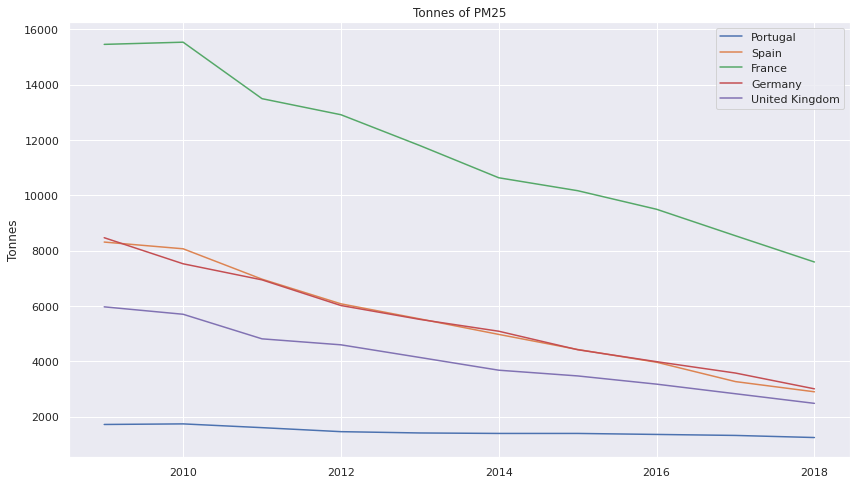

In [42]:
# Tonnes of PM25 particules
plt.figure(figsize=(14,8))
plt.title('Tonnes of PM25')
plt.ylabel('Tonnes')
plt.plot(UE_PM25['Portugal'], label = 'Portugal')
plt.plot(UE_PM25['Spain'], label = 'Spain')
plt.plot(UE_PM25['France'], label = 'France')
plt.plot(UE_PM25['Germany'], label = 'Germany')
plt.plot(UE_PM25['United Kingdom'], label = 'United Kingdom')
plt.legend(loc=1)

The next function allow us found the optimal number of clusters. It bases on Standard Squared Error (SSE), higher the number of clusters lower the error. From a certain number of clusters accuracy doesn't improve, but overfit. Also it makes harder the interpretaion.


So, we will use 4 cluster.

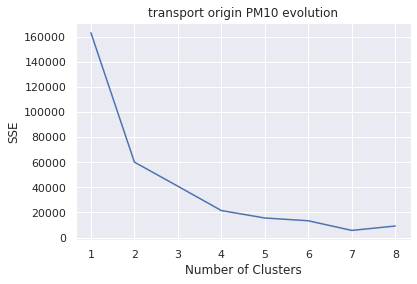

recommended number of cluster =  4


In [66]:
SSE  = []; 

def elbow_clus(list_out, db):
  # Joint in every loop the SSE of the new model with one more cluster than precedant
    for i in range(1,9):
        list_out.append(KMeans(init="random",n_clusters=i,n_init=10,max_iter=300,random_state=None).fit(db).inertia_)
    
    plt.plot(range(1, 9), list_out)
    plt.xticks(range(1, 9))
    plt.title ('transport origin PM10 evolution')
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()
    kl = KneeLocator(range(1, 9), list_out, curve="convex",  direction="decreasing")
    print("recommended number of cluster = ", kl.elbow)  
    
elbow_clus(SSE, UE_PM10[['2018','2009']])

In [44]:
# Analysis Cluster Modelling
UE_PM10 = UE_PM10[UE_PM10.index != 'EU28']
ward = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='ward')

ward = ward.fit_predict(UE_PM10)
UE_PM10["PM10_clus"] = ward

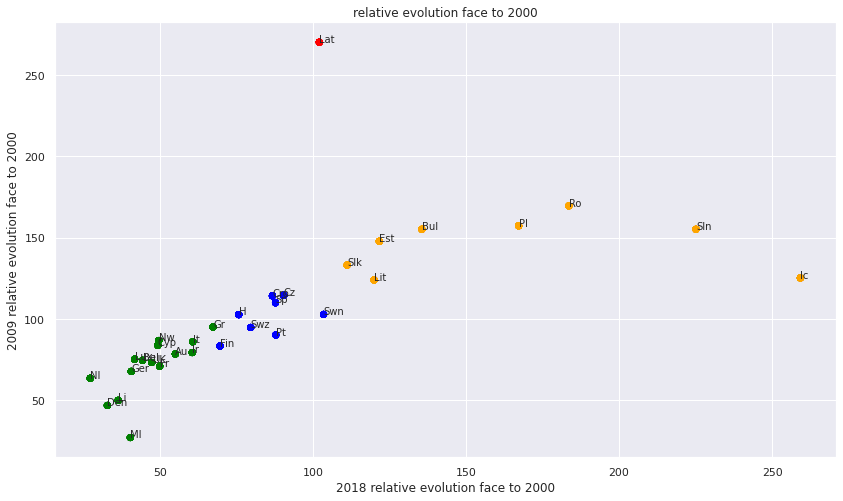

,count,mean
PM10_clus,,
0,8,165.450000
1,15,46.953333
2,1,102.100000
3,8,85.212500


In [46]:
# Plotting the results
colors = {0:'orange', 1:'green',2:'red',3:'blue'}
n = ['Bel','Bul','Cz','Den','Ger','Est','Ir','Gr','Sp','Fr','Cro','It','Cyp','Lat','Lit','Lux','H','Ml','Nl','Au','Pl','Pt','Ro','Sln','Slk','Fin','Swn','Ic','Li','Nw','Swz','UK']

plt.figure(figsize=(14, 8))
plt.ylabel("2009 relative evolution face to 2000")
plt.xlabel("2018 relative evolution face to 2000")
plt.title('PM 10 -- relative evolution face to 2000')

for i, txt in enumerate(n):
    plt.scatter(UE_PM10["2018"],UE_PM10["2009"], c=UE_PM10["PM10_clus"].map(colors))
    plt.annotate(txt, (UE_PM10["2018"][i], UE_PM10["2009"][i]))
plt.show()
UE_PM10.groupby("PM10_clus")["2018"].agg(['count','mean'])

The grafic above represents, in the horizontal axis relative emisions at 2018 face to 2000. In vertical's 2009 relative emisions face at 2000.

Portugal is in Cluster number 3. The mean of emision reduction at 2018 is 85%. Countries which share characteristics with Portugal are: Spain and Czech Republic, but also Finland and Sweden (among others). 

There is a numerous group (Cluster#1) which have decreased its emision more than a half from year 2000 (46%). Specially Malta, Denmark and Netherlands.

Finally we have other two groups, Cluster#2 with only one country: Latvia. Because of its high levels at year 2009 (around 250% face to 2000). Cluster#0 contais countries with relevant polluant emision increasing.

In conclusion, Portugal is in the good direction, but it has to make some efforts in order to achieve the 'cleaner' group.


## Time series modelling

Next step we will build a Time Series model. The goal is to understand the behaviour of the different polluants and try to predict their values for the next days. It is important to make some analysis before applying the respective methods. If not, predictions won't be significant.


### Decomposition and Autocorrelation

Stationarity is the main characteristic one Time Series has to achieve be before introduced in a model. A series is stationary when its mean and variance are independant of time, so they are constant along the entire series.

As any other statistical model, independant variables have to be uncorrelated between them. In Time Series case, these independant variables are the precedant time lags. So, we have to guarantee that series is not Autocorrelated.

When we have a not stationary series or it is autocorrelated there are methods to invoke those characteristics. For example, to transform the series. The most usual transformation carried out is Differentiation, that's to substract to every value the precedant's (so we lost one value).

In order to analyse the stationarity and autocorrelation of every series, we have developped the next function. It applies the Dickey-Fuller method, which is the most used to evaluate the series. It allow us detect which series accomplish stationarity and not autocorrelation, so they are ready to use. Also which ones need to be transformed. 

Function calculates both, transformed and not transformed indicators. It contrasts the null hypothesis that there is autocorrelation, so if p-value is below 0.05 we consider that there is no correlation between the Y moments. Otherwise, Dickey-Fuller recomends to transform the dataset. Dickey-Fuller also calculates Autocorrelation and Partial Autocorrelation plots.

In particular, we have analyse Guincho station, because of practicity. We had not the time of building a model for every station.

In [17]:
data_df = data.copy()
data_df= data_df.set_index('date')
def dickey_fuller_plot(data, freg, polluant):
    
    series = data[data['address'].isin(freg)]
    series = series[series['polluant'].isin(polluant)]['value'].dropna(axis=0, how='any')
    series_dif = (series - series.shift(1))[1:]

    p_value = sm.tsa.stattools.adfuller(series)[1]
    p_value_dif = sm.tsa.stattools.adfuller(series_dif)[1]

    fig = plt.figure(figsize=(12, 7))
    layout = (3,2)
    ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))

    acf_ax_dif = plt.subplot2grid(layout, (2,0))
    pacf_ax_dif = plt.subplot2grid(layout, (2,1))
    
    series.plot(ax=ts_ax)
    ts_ax.set_title('Time Series Analysis Plots\n{2} & {3}\n Dickey-Fuller: p={0:.5f}\n DF diff: p={1:.5f}'.format(p_value,p_value_dif,freg[0], polluant[0]))
    #ts_ax.set_title('freg polluant Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(series, lags=8, ax=acf_ax)
    smt.graphics.plot_pacf(series, lags=8, ax=pacf_ax)
    
    smt.graphics.plot_acf(series_dif, lags=8, ax=acf_ax_dif)
    smt.graphics.plot_pacf(series_dif, lags=8, ax=pacf_ax_dif)

    plt.tight_layout()

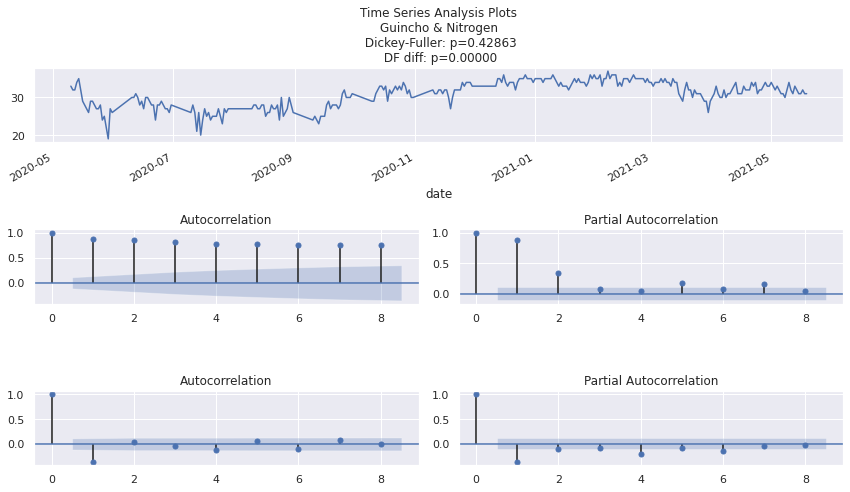

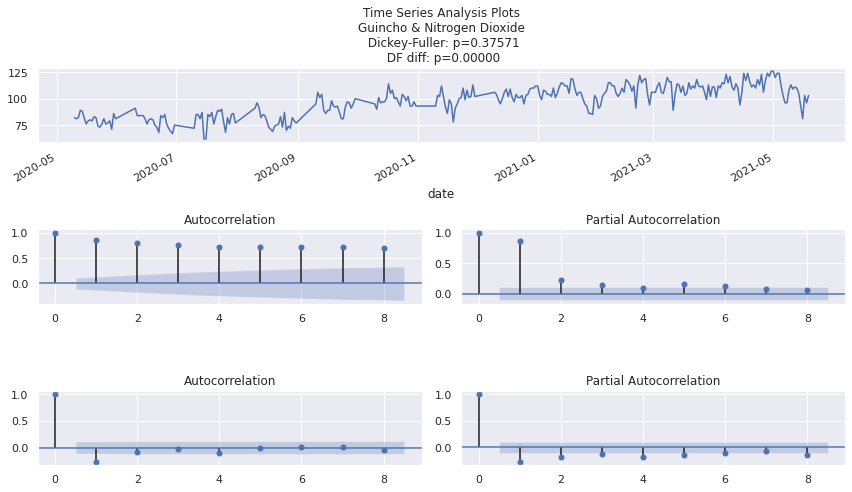

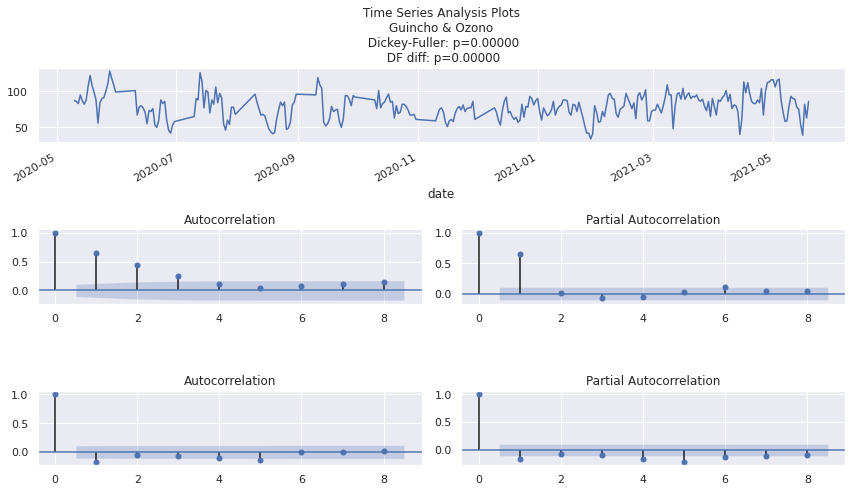

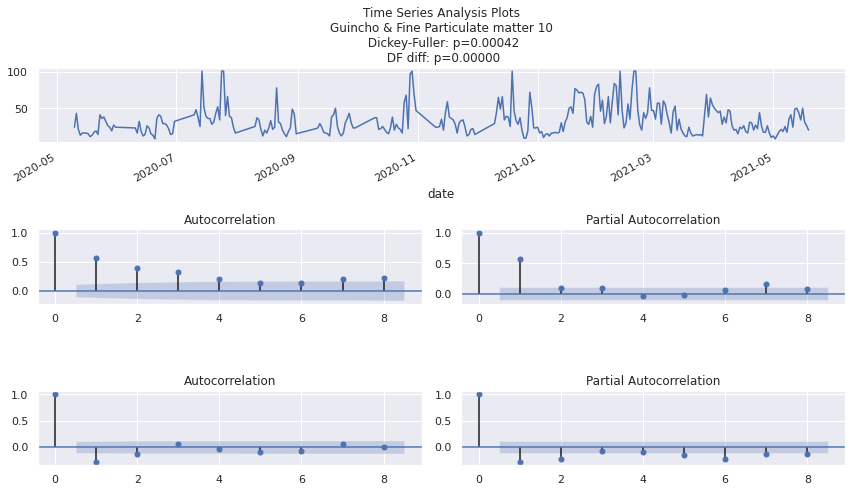

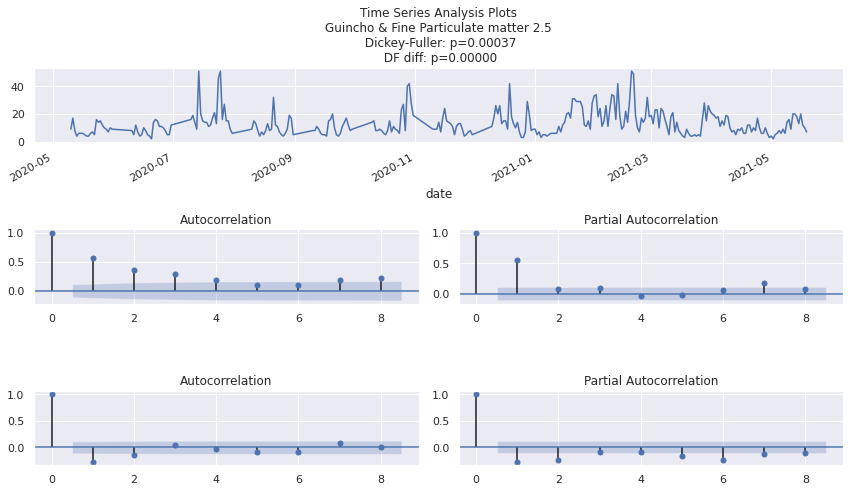

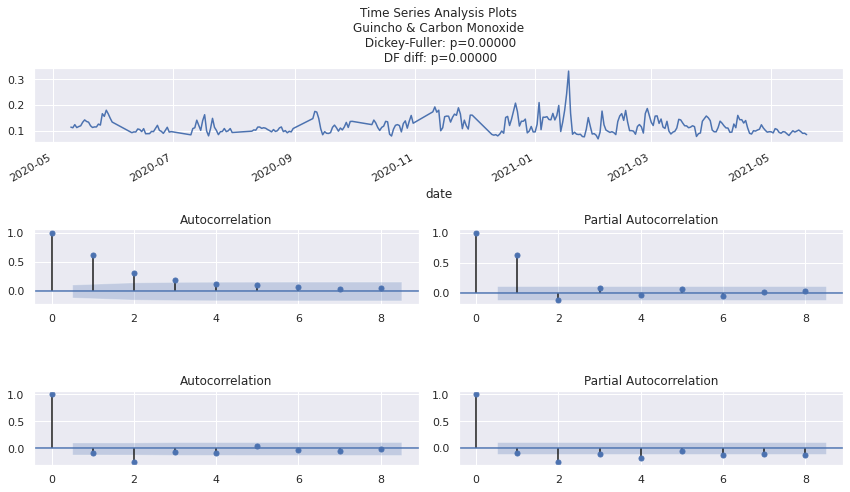

In [18]:

dickey_fuller_plot(data_df,['Guincho'], ['Nitrogen'])
dickey_fuller_plot(data_df,['Guincho'], ['Nitrogen Dioxide'])
dickey_fuller_plot(data_df,['Guincho'], ['Ozono'])
dickey_fuller_plot(data_df,['Guincho'], ['Fine Particulate matter 10'])
dickey_fuller_plot(data_df,['Guincho'], ['Fine Particulate matter 2.5'])
dickey_fuller_plot(data_df,['Guincho'], ['Carbon Monoxide'])

First of all we have the dickey fuller p-value, and the observed values representation.

On the other hand, we have the two other charts, correlogram and partial correlogram (The second Correlogram plots are from differenciated series).

Autocorrelation plots interpret internal association between observations, the closer to 1 (or -1) the highest correlation between lags. When correlation in some lag is under the shadow it means that correlation is considered equal to 0, so there is not correlation.

The partial correlogram is a summary of the relationship between an observation in a time series with other prior observation, removing the relationship of observations conteined between them.

As we see series are stationary, except Nitrogen and Nitrogen Dioxide, which after transformation are effectevly stationary.

### Training and validation

Next, we separate dataframe in training and validation for every station. We will train the model with data untill end April'21. Then we validate with the next 20 days.

In [5]:
#creating the train and validation set
data = data.sort_values('date')
train = data.loc[data['date'] <= '2021-04-30']
valid = data.loc[data['date'] > '2021-04-30']

dict_train = {}
dict_valid = {}
freg_list = [['Parede'],['Malveira'],['Guincho'],['Aboboda'],['Murtal'],['Manique'],['Alcabideche'],['Rebelva'],['Cascais'],['Estoril']]
polluant_list = [['Nitrogen'],['Nitrogen Dioxide'],['Ozono'],['Fine Particulate matter 1.0'],['Fine Particulate matter 2.5'],['Carbon Monoxide']]

def data_separation(freg_list,polluant_list,dict_train,dict_valid):
  for i in range(len(freg_list)):
      
      series_train = train[train['address'].isin([freg_list[i][0]])]
      series_valid = valid[valid['address'].isin([freg_list[i][0]])]
      dict_train["train_{0}".format(freg_list[i])] = series_train
      dict_valid["valid_{0}".format(freg_list[i])] = series_valid

data_separation(freg_list,polluant_list,dict_train,dict_valid)

In [6]:
train_aboboda = dict_train["train_['Aboboda']"].pivot_table(values = 'value', index = 'date', columns = 'polluant', fill_value = 0).round(2)
train_alcabideche = dict_train["train_['Alcabideche']"].pivot_table(values = 'value', index = 'date', columns = 'polluant', fill_value = 0).round(2)
train_Cascais = dict_train["train_['Cascais']"].pivot_table(values = 'value', index = 'date', columns = 'polluant', fill_value = 0).round(2)
train_Estoril = dict_train["train_['Estoril']"].pivot_table(values = 'value', index = 'date', columns = 'polluant', fill_value = 0).round(2)
train_Guincho = dict_train["train_['Guincho']"].pivot_table(values = 'value', index = 'date', columns = 'polluant', fill_value = 0).round(2)
train_Malveira = dict_train["train_['Malveira']"].pivot_table(values = 'value', index = 'date', columns = 'polluant', fill_value = 0).round(2)
train_Manique = dict_train["train_['Manique']"].pivot_table(values = 'value', index = 'date', columns = 'polluant', fill_value = 0).round(2)
train_Murtal = dict_train["train_['Murtal']"].pivot_table(values = 'value', index = 'date', columns = 'polluant', fill_value = 0).round(2)
train_Parede = dict_train["train_['Parede']"].pivot_table(values = 'value', index = 'date', columns = 'polluant', fill_value = 0).round(2)
train_Rebelva = dict_train["train_['Rebelva']"].pivot_table(values = 'value', index = 'date', columns = 'polluant', fill_value = 0).round(2)

valid_aboboda = dict_valid["valid_['Aboboda']"].pivot_table(values = 'value', index = 'date', columns = 'polluant', fill_value = 0).round(2)
valid_alcabideche = dict_valid["valid_['Alcabideche']"].pivot_table(values = 'value', index = 'date', columns = 'polluant', fill_value = 0).round(2)
valid_Cascais = dict_valid["valid_['Cascais']"].pivot_table(values = 'value', index = 'date', columns = 'polluant', fill_value = 0).round(2)
valid_Estoril = dict_valid["valid_['Estoril']"].pivot_table(values = 'value', index = 'date', columns = 'polluant', fill_value = 0).round(2)
valid_Guincho = dict_valid["valid_['Guincho']"].pivot_table(values = 'value', index = 'date', columns = 'polluant', fill_value = 0).round(2)
valid_Malveira = dict_valid["valid_['Malveira']"].pivot_table(values = 'value', index = 'date', columns = 'polluant', fill_value = 0).round(2)
valid_Manique = dict_valid["valid_['Manique']"].pivot_table(values = 'value', index = 'date', columns = 'polluant', fill_value = 0).round(2)
valid_Murtal = dict_valid["valid_['Murtal']"].pivot_table(values = 'value', index = 'date', columns = 'polluant', fill_value = 0).round(2)
valid_Parede = dict_valid["valid_['Parede']"].pivot_table(values = 'value', index = 'date', columns = 'polluant', fill_value = 0).round(2)
valid_Rebelva = dict_valid["valid_['Rebelva']"].pivot_table(values = 'value', index = 'date', columns = 'polluant', fill_value = 0).round(2)#.sort_index(ascending = True)
#train_Rebelva


### Modelling

There are several informations in every station, such as polluants and metheorologic data. As it is recommended we have tried to build a model with all these informations. We have tested the different stations and predicting all the indicators, such as the first ARIMA Model Results, which try to modelize PM2.5 as dependent variable, through every polluant variable (Ozono, PM2.5, PM10, Nitrogen, Nitrogen Dioxide and Carbon Monoxide). Every test we perform was not conclusive.



In [7]:
model3=sm.tsa.ARIMA(endog=train_Cascais['Fine Particulate matter 2.5'],exog=train_Cascais[['Ozono','Fine Particulate matter 2.5','Fine Particulate matter 10','Carbon Monoxide','Nitrogen','Nitrogen Dioxide']],order=[1,1,1])
results3=model3.fit()
print(results3.summary())

                                   ARIMA Model Results                                   
Dep. Variable:     D.Fine Particulate matter 2.5   No. Observations:                  292
Model:                            ARIMA(1, 1, 1)   Log Likelihood                -838.385
Method:                                  css-mle   S.D. of innovations              4.273
Date:                           Fri, 28 May 2021   AIC                           1696.770
Time:                                   12:50:22   BIC                           1733.538
Sample:                                        1   HQIC                          1711.498
                                                                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   5.2205      3.900      1.339    

So, finally we will build an univariate model. In particular an ARIMA model, which means Auto Regressive Integrated Moving Average.

AR stands for Auto Regressive, so the model is built based on the previous lags, we try to find the future value using the information of the last time steps.

MA stands for Moving Average. The goal is to create a time series from Residual errors, obtained in the forecast of the series, and then we also can model this data.

Predicting these errors allows us to subtract in the AutoRegressive forecasting. So, if on one side, we forecast the next value of the series, and then, we correct it with the error prediction, the model provides us an additional fit in performance

For a better understanding, an autoregression of the residual errors is the Moving Average model.

The next function (optimize_ARIMA) find the model with lowest AIC. It tests several models changing the order parameters p,d and q. Which determine the number of lags for Autorregresive and Moving Average models (parameters p and q). d inputs the integration parameter, which indicates the number of differentations series needs to be stationary.


In [22]:
#Set initial values and some bounds
p = range(0, 5)
d = 1 # have to see if Ozono and PM25 in every freguesia need transformation. make parameter in function call
q = range(0, 5)

#Create a list with all possible combinations of parameters
parameters = product(p, q)
parameters_list = list(parameters)
parameters_list[0:5]

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]

In [ ]:
def optimize_ARIMA(parameters_list, datArima, d):
    """
        We enter a univariate series and the function returns a dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q) tuples
        d - integration order
        p - AR time laps
        q - MA time laps
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = ARIMA(datArima, order=(param[0], d, param[1]))
            model_fit = model.fit(disp=-1)
        except:
            continue
            
        aic = model_fit.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model_fit
            best_aic = aic
            best_param = param
        results.append([param, model_fit.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

train_Guincho_result_Nitrogen = optimize_ARIMA(parameters_list, train_Guincho['Nitrogen'], 1)
#train_Guincho_result_Ozono = optimize_ARIMA(parameters_list, train_Guincho['Ozono'], 1)
#train_Guincho_result_Nitrogen_diox = optimize_ARIMA(parameters_list, train_Guincho['Nitrogen Dioxide'], 1)
#train_Guincho_result_PM10 = optimize_ARIMA(parameters_list, train_Guincho['Fine Particulate matter 10'], 1)

Following Decomposition and autocorrelation guidelines we wild build  an ARIMA model for Guincho and its Nitrogen sensor. The function have recommended to build an ARIMA(1,1,4). Remember that Guincho Nitrogen needed one differentation to be stationary.

In [106]:
train_Guincho_result_Nitrogen.head(5)

,parameters,aic
0,"(1, 4)",1091.516426
1,"(4, 3)",1092.071335
2,"(4, 1)",1092.725911
3,"(0, 4)",1092.751218
4,"(0, 3)",1093.284690


Model summary. The p-value of every explicative time lag under 0.05, so they all are significative.

In [17]:
model = ARIMA(train_Guincho['Nitrogen'], order=(1, 1, 4))
model_fit = model.fit(disp=-1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.Nitrogen   No. Observations:                  292
Model:                 ARIMA(1, 1, 4)   Log Likelihood                -538.758
Method:                       css-mle   S.D. of innovations              1.529
Date:                Fri, 28 May 2021   AIC                           1091.516
Time:                        12:53:48   BIC                           1117.254
Sample:                             1   HQIC                          1101.826
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0024      0.034      0.072      0.942      -0.064       0.069
ar.L1.D.Nitrogen    -0.9313      0.037    -25.381      0.000      -1.003      -0.859
ma.L1.D.Nitrogen     0.4847 

Next function represents the forecast made from the ARIMA model, also the error calculation and residuals analysis.Predictions are represented as the green line in the grafic.

We define three error indicators in order to quantify the goodness of our predictions. 

 - MAPE, Mean Absolute Percentage Error
 - MAE, Mean Absolute Error
 - RMSE, Root Mean Squared Error



{'mape': 0.0389029055433165, 'mae': 1.2208293744202243, 'rmse': 1.4433905920483656}


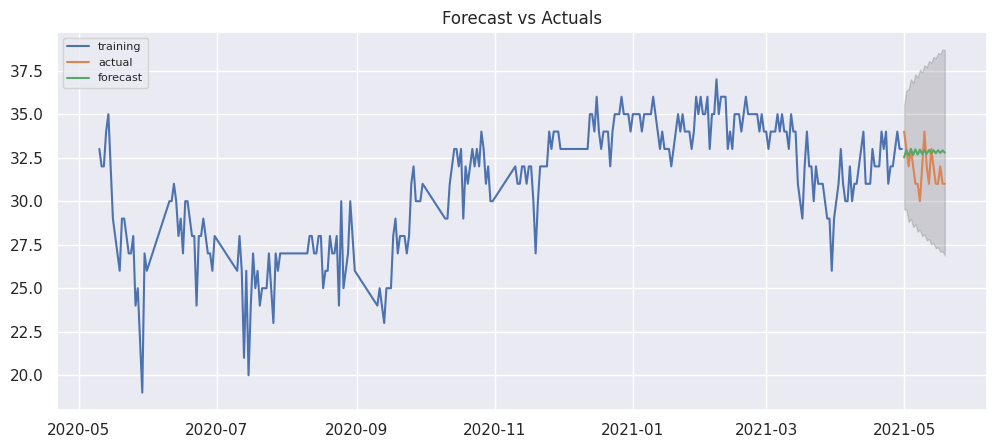

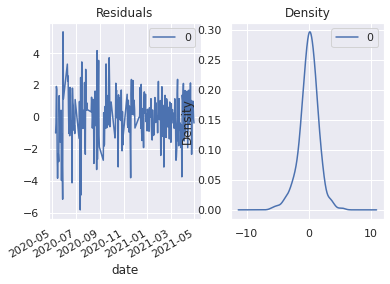

In [18]:
def forecast_resid_error(train_data, valid_data):  
  # Forecast
  fc, se, conf = model_fit.forecast(19, alpha=0.05)  # 95% conf
  train_series = train_data
  valid_series = valid_data
  series = pd.concat([train_series, valid_series])
  
  # Error calculation
  mape = np.mean(np.abs(fc - valid_data)/np.abs(valid_data))
  mae = np.mean(np.abs(fc - valid_data))    
  rmse = np.mean((fc - valid_data)**2)**.5  

  print({'mape':mape,'mae': mae,'rmse':rmse})

  # lower and upper limits
  fc_series = pd.Series(fc, index=valid_series.index)
  lower_series = pd.Series(conf[:, 0], index=valid_series.index)
  upper_series = pd.Series(conf[:, 1], index=valid_series.index)

  # Plot
  plt.figure(figsize=(12,5), dpi=100)
  plt.plot(train_data, label='training')
  plt.plot(valid_data, label='actual')
  plt.plot(fc_series, label='forecast')
  plt.fill_between(lower_series.index, lower_series, upper_series, 
                  color='k', alpha=.15)
  plt.title('Forecast vs Actuals')
  plt.legend(loc='upper left', fontsize=8)
  #plt.show()

  # Plot residual errors
  residuals = pd.DataFrame(model_fit.resid)
  fig, ax = plt.subplots(1,2)
  residuals.plot(title="Residuals", ax=ax[0])
  residuals.plot(kind='kde', title='Density', ax=ax[1])
  plt.show()
forecast_resid_error(train_Guincho['Nitrogen'],valid_Guincho['Nitrogen'])

The forecast get wrong only in 3.8% (according to MAPE) which is really good.

Residuals are the difference between fitted and observed values. It is very important to analyse them, because they can give us information about how the model is fitting. There are two main properties that residuals have to achieve.

First one, residuals must be uncorrelated between them. If not, it means that exists an information, which is not being used, remaining in the residuals. On the other hand, residuals must have mean zero. If these two requests are not met, our model has not adequately captured the information.


In [25]:
frcst = pd.DataFrame({'meses':valid_Guincho['Nitrogen'].index,'frcst':fc,'test':valid_Guincho['Nitrogen'],
                      'dif': fc-valid_Guincho['Nitrogen'],'dif%': fc/valid_Guincho['Nitrogen']})
frcst['meses'] = pd.to_datetime(frcst['meses'], format='%Y%m')
frcst = frcst.set_index('meses')
frcst.head(5)

,frcst,test,dif,dif%
meses,,,,
2021-05-01,32.514274,34,-1.485726,0.956302
2021-05-02,32.934833,33,-0.065167,0.998025
2021-05-03,32.616826,32,0.616826,1.019276
2021-05-04,32.998430,33,-0.001570,0.999952
2021-05-05,32.647737,32,0.647737,1.020242


The table above show us the predictions for the next 5 days. 

## BI Tool

Information is power, so we are developing a tool which allow intitutions and people know how is the air quality today and in the nex 5 days, thanks to our predictions. The software we have chosen is Microsoft Power BI. It allows create different dashboards, input filters and make zoom for every dimension. 


The goal is to colour every station following our predictions and QUALAR standards. This tool helps authorities to make plannings to control high polluant levels and users to understand what air quality means and its consequencies.

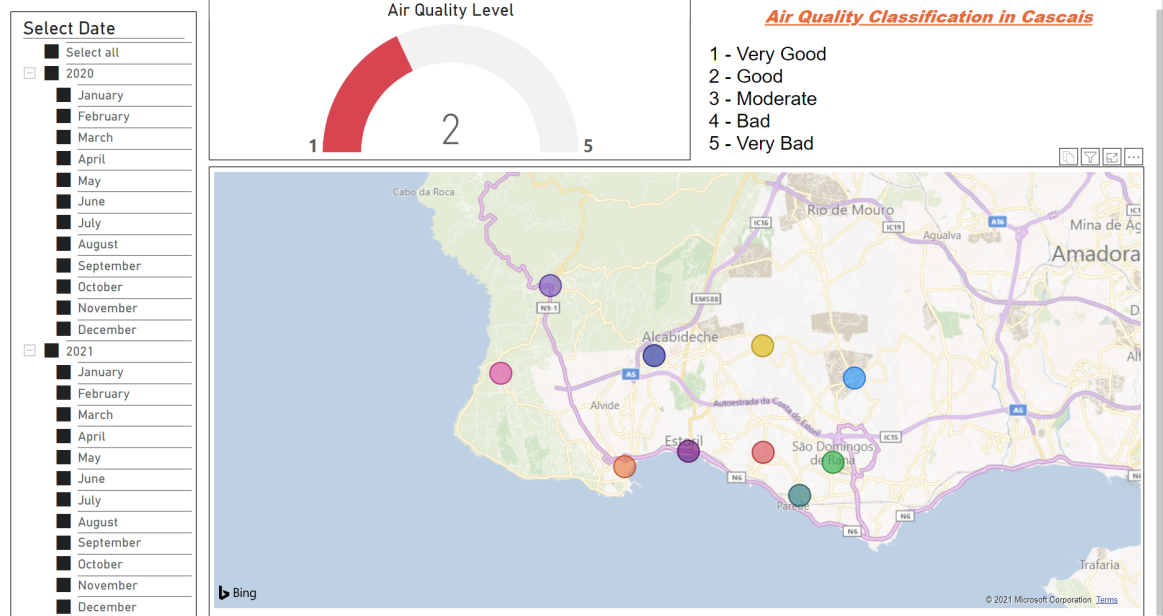

## Big solutions for big challenges

We understand that solution to air quality must pass through two points, people knowledge and engagement. Anything is going to change significantly with out people implication. Gouvernments and institutions can put the number of sensors they want, wherever they consider. If people don't know what they are breathing, its consequencies and how to change it, air quality never is not going to improve. 

So, in order to combat these two deficiencies we propose a series of measures and iniciatives.

 - The first, and more important, is to create comitees where neighbours can delibarate about air quality situation. They analyse current situation, they examine the consequencies and how to save them. The composition of these meetings should be elected by raffle (equally distributed by sex, age and other socio-economic factors) and be remunerated, in order to guarantee diversification and presence of every social class, assuring not leaving no one behind. It would be recomendable to get an academic training to participants. The goal is to make people participate, so the members of the round tables should be rotatory. 

   Some of the proposals could arise from these assemblies could be for example, the creation of a Label in every product we buy. This label would inform about the environment footprint of that product. Like right now with food products which inform about the nutritional facts or Bio foods which they have their own label. This new classification would be based on the number of kilometers traveled for every component of the good until reach the store or client house. Also we could considerate the tonnes of polluant gases emited in the industry where they come (if applicable) or if the final packing is reusable. 

  Doing this, every time we buy something we are conscious of the carbon footprint we are generating by achieving this article. So, the next question is, What can we do, as users, to not leave this environment mark? Nothing is produced in the cities, everything is imported, so how can we reduce the number of kilometers of our products?

 - The answer is by optimizing city spaces. We could use the current green zones to create community gardens where neighbours would participate. In these gardens we would plant vegetables which would be eaten or sold in local markets. Obviously these products would be labeled with "Beyond Zero", because they don't have any additive and their number of kilometers would be very low, so their carbon footprint would be almost nule. If people prefer to buy online their products from home, the delivery could be done by bike.

  It is important to make people work in their gardens, in order to increase encouragement. The depth of this action lies on children education. The impression we give them. They should grow up watching these gardens as another routinary thing in their lives (like going to the school), and not to buy food in the supermarket like if apples would grow from the shelves.

  Furthermore, schools, universities, companies and other institutions could organize activities to collaborate and learn how to work on gardens and other environment respectfull iniciatives.

  Finally, with community gardens people will understand how the climate change concern right now. Nowadays, farmers already suffer harvest freeze and droughts. Also we will learn how eliminating a little mosquito specie can become in plagues. Without doubt it is the best way to make us understand the importance of climate in our lifes.

 - On the other hand, based in Qualar.pt indicators, we propose restrictions for the days and areas in which air quality is worse than 'Good'. The goal is to reduce the impact by reducing the number of people exposed to this 'bad atmosphere'. So, green zones (or other areas) capacity could be limited.

- Other restrictions we recommend to carry out are about traffic. According to Environment European Agency and UNO, traffic is the main cause of air pollution. So, we propose traffic limitations the days that air quality is not 'Good', such as, speed reduction, intensity restrictions (through number plate) and vehicule ocupation controlling. 

  Today you can go with yours 6 friends to the beach in 6 different cars, but may be the next week you won't be allowed, because PM2.5 is too high. Other wise, if you choose share your car or use public transport the next weekend air quality won't be degradated.

  This is a relly important point, people need to see the results of their actions. If they are irresponsible, some days later they will have some restrictions in green areas or traffic. If not they never be restricted. 

- It would be desiderable to activate a publicity campaign explaining why and how these measures are applied, as well as the benefits they carry out. For example we could install air quality indicators in bus stops and gas stations which would inform about the current situation and the prevision for the next days. Handle these information people could make data scientist mistake, because if people know that prevision in the next days will be bad, they can change their habits and then three days later air quality is not bad, but moderate or good, and restrictions are eliminated.

Some actions have started along entire planet, such as the clean air marathon. It is not running, but doing 42Km by walking, riding bike, using public transport... Also some information campaigns in which you can see how many annualy deaths are in your city related to air quality, 3.276 in Cascais. https://breathelife2030.org/city_data/cascais/
